In [1]:
import Bio.PDB

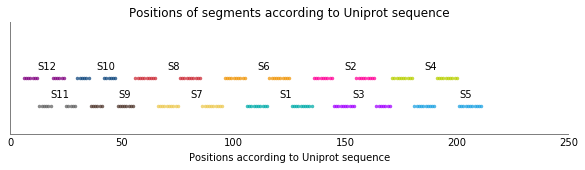

Calculating changes in properties:
   Average residue mass (daltons)
   Monoisotopic mass (daltons)
   Occurrence in proteins, %
   Average volume of buried residues, A3
   Van der Waals volume, A3
   Accessible surface area, A2
   Fraction of buried among this aa
   Fraction of buried among all buried
   Polarity average ranking
   Polarity ranking (Radzicka and Wolfenden 1988)


/Users/karen/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1101: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['aa_seq', 'mut_list', 'mut_list_Scer', 'mut_list_Scer_full']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


1886 unique mutations across all segments
238 natural unique mutations across all segments
There are 231 single mutations with known effects. They are found in 120 positions


Now the following variables are available:

- data: all data as a (sorted) dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe'

- unique_single_mutations: a dictionary with all single mutations for every segment

- data_singles: a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe' for genotypes containing a single substitution

- single_mut_fitness_dict: a dictionary in the form: 'single mutation' : 'fitness'

- data_known_mutations_only: a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe', 
but only for those genotypes that consist of mutations with known effects (single mutant is measured).
For this dictionary, epistasis is measured for every genotype

- aa_properties: a pandas DataFrame summarizing properties of amino acids,


In [65]:
% run 'ks01_Data_import.ipynb'

In [41]:
import Bio.PDB
import numpy as np
import os
from matplotlib import pyplot as plt
% matplotlib inline

In [115]:
ascii_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

def get_atom_distance(atom1, atom2):
    diff_vector  = atom1.coord - atom2.coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

def calc_residue_dist(residue_one, residue_two, mode='min'):
    assert mode in ['CA', 'min']
    if mode == 'CA':
        diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
        return np.sqrt(np.sum(diff_vector * diff_vector))
    if mode == 'min':
        distances = []
        for atom1 in residue_one.get_atom():
            for atom2 in residue_two.get_atom():
                distances.append(get_atom_distance(atom1, atom2))
        return min(distances)

def strip_non_aa_residues(residues):
    for index, residue in enumerate(residues):
        if residue.resname not in aa3:
            break
    residues = residues[:index]
    return residues

def dist_to_other_residues(residue, all_residues, distance_type='CA'):
    distances = np.empty_like(all_residues)
    for index, other_residue in enumerate(all_residues):
        distances[index] = calc_residue_dist(residue, other_residue)
    return distances

def calc_dist_matrix(chain1, chain2, stripping=True):
    """Returns a matrix of C-alpha distances between two chains"""
    chain1_residues = strip_non_aa_residues(list(chain1.get_residues()))
    chain2_residues = strip_non_aa_residues(list(chain2.get_residues()))
    answer = np.zeros((len(chain1_residues), len(chain2_residues)), np.float)
    for row, residue_one in enumerate(chain1_residues):
        for col, residue_two in enumerate(chain2_residues) :
            answer[row, col] = calc_residue_dist(residue_one, residue_two)
    return answer


def get_minimal_distances_in_a_complex(chains):
    distances = []
    chains = [chain for chain in chains if chain.id in ascii_letters]
    for chain1 in chains:
        for chain2 in chains:
            distances.append(calc_dist_matrix(chain1, chain2))
    return np.amin(np.array(distances), axis=0)

In [108]:
files_dump_folder = '/Users/karen/HIS3InterspeciesEpistasis/Analysis/Karen/files_dump/'
aa3 = "ALA CYS ASP GLU PHE GLY HIS ILE LYS LEU MET ASN PRO GLN ARG SER THR VAL TRP TYR XXX".split()

In [109]:
pdb_file = os.path.join(files_dump_folder, 'structure_predictions', 'HIS3_saccharomyces_cerevisiae__swissmodel_prediction.pdb')
structure = Bio.PDB.PDBParser().get_structure('His3_itasser', pdb_file)
model = structure[0]

In [110]:
%run 'functions_dump.py'

def plot_segment_positions(ax, scale=1):
    old_y = 2*scale
    for row in positions.iterrows():
        for position in row[1].positions_Uniprot_P06633:
            new_y = np.random.choice([1*scale, 2*scale])
            while new_y == old_y:
                new_y = np.random.choice([1*scale, 2*scale])
        x = row[1].positions_Uniprot_P06633
        plt.plot(x, [new_y for e in x], '.', lw=3, alpha=0.7, 
            label=row[1].segment, color=segment_colors[row[1].segment])
        plt.text(np.median(x), new_y + 2*scale, row[1].segment)
        old_y = new_y

In [116]:
structure_files = {'itasser' : os.path.join(files_dump_folder, 'structure_predictions', 
                                       'HIS3_saccharomyces_cerevisiae__itasser_model1_prediction.pdb'),
             'swissmodel' : os.path.join(files_dump_folder, 'structure_predictions', 
                                       'HIS3_saccharomyces_cerevisiae__swissmodel_prediction.pdb'),
             'assembly' : os.path.join(files_dump_folder, 'structure_visualizations', 
                                         'His3_aligned_with_4LOM_assembly_by_Sasha.pdb')}

chain_lists = {}
for k, pdb_file in structure_files.items():
    structure = Bio.PDB.PDBParser().get_structure('His3_itasser', pdb_file)
    chains = [list(model.get_chains()) for model in list(structure.get_models())]
    

    chain_lists[k] = 

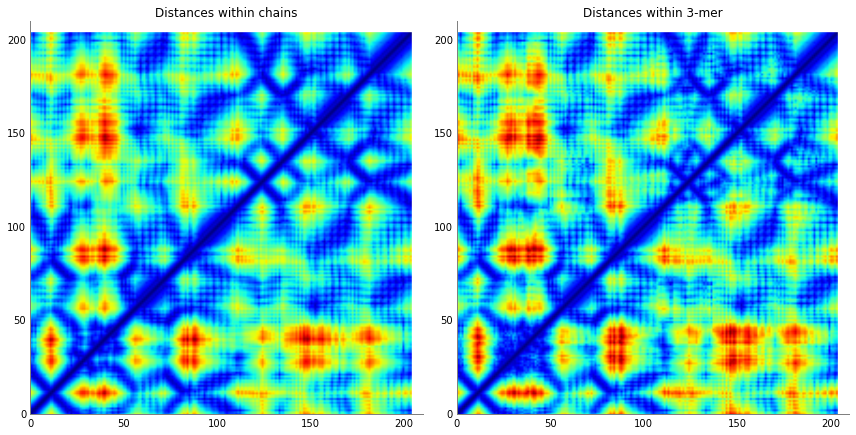

In [113]:
plot_better(width=12, height=8)

ax = plt.subplot(131)
improve_plot(ax, grid='none')
chain1 = [c for c in list(model.get_chains())][0]
plt.imshow(get_minimal_distances_in_a_complex([chain1]), origin='lower')
plt.title('Minimal distance within chains')
plt.xlim(0,210)
plt.ylim(0,210)


ax = plt.subplot(132)
improve_plot(ax, grid='none')
plt.imshow(get_minimal_distances_in_a_complex(model.get_chains()), origin='lower')
plt.title('Minimal distance within 3-mer')
plt.xlim(0,210)
plt.ylim(0,210)


ax = plt.subplot(133)
improve_plot(ax, grid='none')

pdb_file = os.path.join(files_dump_folder, 'structure_visualizations', 'His3_aligned_with_4LOM_assembly_by_Sasha.pdb')
structure = Bio.PDB.PDBParser().get_structure('His3_itasser', pdb_file)
chains = [list(model.get_chains())[0] for model in list(structure.get_models())]

plt.imshow(get_minimal_distances_in_a_complex(chains), origin='lower')
plt.title('Minimal distance within 24-mer')
plt.xlim(0,210)
plt.ylim(0,210)

plt.tight_layout()

KeyboardInterrupt: 

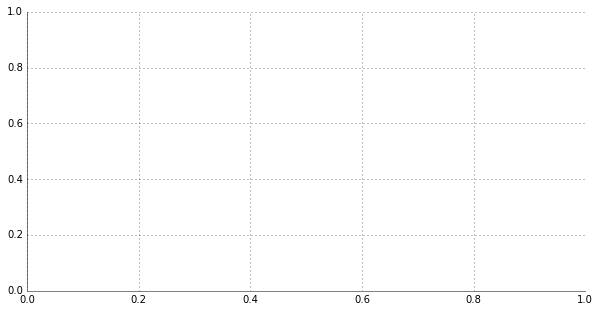

In [131]:
plot_better()
pdb_file = os.path.join(files_dump_folder, 'structure_visualizations', 'His3_aligned_with_4LOM_assembly_by_Sasha.pdb')
structure = Bio.PDB.PDBParser().get_structure('His3_itasser', pdb_file)
chains = [list(model.get_chains())[0] for model in list(structure.get_models())]
min_distances = get_minimal_distances_in_a_complex(chains)
plt.imshow(get_minimal_distances_in_a_complex(chains), origin='lower')
plt.title('Minimal distance within 24-mer')
plt.xlim(0,210)
plt.ylim(0,210)

plt.tight_layout()